<a href="https://colab.research.google.com/github/ayulockin/myDLexperiments/blob/master/Understanding_One_Shot_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspired by this video: https://www.youtube.com/watch?v=H4MPIWX6ftE&t=414s <br>
Refered this code: https://github.com/lukas/ml-class/blob/master/videos/one-shot/One%20Shot.ipynb

In [1]:
!pip install tensorflow==2.0.0 -q

     |████████████████████████████████| 86.3MB 67kB/s 
     |████████████████████████████████| 3.8MB 45.0MB/s 
     |████████████████████████████████| 450kB 59.0MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import random
import numpy as np

In [4]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train/255.0
x_test = x_test/255.0

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


In [5]:
print("X_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", x_test.shape)
print("y_test: ", y_test.shape)

X_train:  (60000, 28, 28)
y_train:  (60000,)
X_test:  (10000, 28, 28)
y_test:  (10000,)


One shot learning is usually applied when we are limited with training data. We build a pair of images and assign it a label which is either 0 or 1 which denotes with they are not similar or similar respectively. As you can understand that we are able to classify using few examples. We concretely know that one example belong to a particular label. Other images can be either similar or not similar to that concrete example. 

Siamese network is one such network we will build here. 

In [0]:
# make pairs
def make_pairs(x, y, num_classes):
    num_classes = num_classes
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [1]
    
        # add a not matching example
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels)

In [0]:
pairs_train, labels_train = make_pairs(x_train, y_train, 10)
pairs_test, labels_test = make_pairs(x_test, y_test, 10)

In [8]:
print("X_train_pair: ", pairs_train.shape)
print("y_train_pair: ", labels_train.shape)
print("X_test_pair: ", pairs_test.shape)
print("y_test_pair: ", labels_test.shape)

X_train_pair:  (120000, 2, 28, 28)
y_train_pair:  (120000,)
X_test_pair:  (20000, 2, 28, 28)
y_test_pair:  (20000,)


Let's visualize pairs

In [0]:
import matplotlib.pyplot as plt

%matplotlib inline

Label for the pair in row 0 is: 0
Label for the pair in row 1 is: 1
Label for the pair in row 2 is: 0
Label for the pair in row 3 is: 1


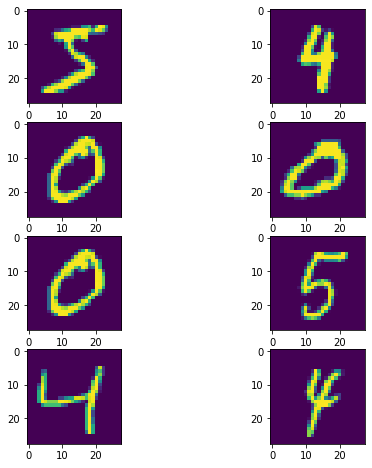

In [31]:
# take a peek at the data
rows = 4
cols = 2

# sample_pairs = [random.randint(0, pairs_train.shape[0]) for _ in range(rows)]
sample_pairs = [1,2,3,4]


fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(8,8))
for row in range(rows):
  axs[row][0].imshow(pairs_train[sample_pairs[row],0])
  axs[row][1].imshow(pairs_train[sample_pairs[row],1])
  print('Label for the pair in row {} is: {}'.format(row, labels_train[sample_pairs[row]]))

In [0]:
from tensorflow.keras import backend as K

## Without weight sharing. 

After all the set of transformations on one image by one leg should be same on other image. And then the decision of similarity makes sense.

In [0]:
K.clear_session()

seq1 = tf.keras.models.Sequential()
seq1.add(tf.keras.layers.Flatten(input_shape=(28,28)))
seq1.add(tf.keras.layers.Dense(128, activation='relu'))

seq2 = tf.keras.models.Sequential()
seq2.add(tf.keras.layers.Flatten(input_shape=(28,28)))
seq2.add(tf.keras.layers.Dense(128, activation='relu'))

merge_layer = tf.keras.layers.Concatenate()([seq1.output, seq2.output])
dense_layer = tf.keras.layers.Dense(1, activation="sigmoid")(merge_layer)
model = tf.keras.models.Model(inputs=[seq1.input, seq2.input], outputs=dense_layer)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
flatten_input (InputLayer)      [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_1_input (InputLayer)    [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           flatten_input[0][0]              
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           flatten_1_input[0][0]            
______________________________________________________________________________________________

In [0]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [15]:
hist = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=256, epochs= 5)

Train on 120000 samples
Epoch 1/5
120000/120000 [==============================] - 6s 47us/sample - loss: 0.6962 - accuracy: 0.5006
Epoch 2/5
120000/120000 [==============================] - 5s 40us/sample - loss: 0.6928 - accuracy: 0.5182
Epoch 3/5
120000/120000 [==============================] - 5s 39us/sample - loss: 0.6922 - accuracy: 0.5181
Epoch 4/5
120000/120000 [==============================] - 5s 40us/sample - loss: 0.6916 - accuracy: 0.5241
Epoch 5/5
120000/120000 [==============================] - 5s 40us/sample - loss: 0.6908 - accuracy: 0.5274


It appears that even after being trained on so so many examples it learned nothing. It's random guessing.

## Weight sharing

In [0]:
K.clear_session()

input = tf.keras.layers.Input((28,28))
x = tf.keras.layers.Flatten()(input)
x = tf.keras.layers.Dense(128, activation='relu')(x)
dense = tf.keras.models.Model(input, x)

input1 = tf.keras.layers.Input((28,28))
input2 = tf.keras.layers.Input((28,28))

dense1 = dense(input1)
dense2 = dense(input2)

merge_layer = tf.keras.layers.Concatenate()([dense1, dense2])
dense_layer = tf.keras.layers.Dense(1, activation="sigmoid")(merge_layer)
model = tf.keras.models.Model(inputs=[input1, input2], outputs=dense_layer)

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 128)          100480      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           model[1][0]                

In [0]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [19]:
hist = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=256, epochs=5)

Train on 120000 samples
Epoch 1/5
120000/120000 [==============================] - 5s 44us/sample - loss: 0.6962 - accuracy: 0.4987
Epoch 2/5
120000/120000 [==============================] - 5s 40us/sample - loss: 0.6930 - accuracy: 0.5106
Epoch 3/5
120000/120000 [==============================] - 5s 40us/sample - loss: 0.6925 - accuracy: 0.5205
Epoch 4/5
120000/120000 [==============================] - 5s 39us/sample - loss: 0.6923 - accuracy: 0.5216
Epoch 5/5
120000/120000 [==============================] - 5s 40us/sample - loss: 0.6917 - accuracy: 0.5281


## Custom ops-Euclidean Distance

Both images are transformed by a single network(shared weights) thus some sort of distance separation should be performed between different embedding of image pairs.  

In [0]:
K.clear_session()

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


input = tf.keras.layers.Input((28,28))
x = tf.keras.layers.Flatten()(input)
x = tf.keras.layers.Dense(128, activation='relu')(x)
dense = tf.keras.models.Model(input, x)

input1 = tf.keras.layers.Input((28,28))
input2 = tf.keras.layers.Input((28,28))

dense1 = dense(input1)
dense2 = dense(input2)

merge_layer = tf.keras.layers.Lambda(euclidean_distance)([dense1,dense2])
dense_layer = tf.keras.layers.Dense(1, activation="sigmoid")(merge_layer)
model = tf.keras.models.Model(inputs=[input1, input2], outputs=dense_layer)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 128)          100480      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [0]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [23]:
hist = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=256, epochs=5)

Train on 120000 samples
Epoch 1/5
120000/120000 [==============================] - 5s 45us/sample - loss: 0.7119 - accuracy: 0.4989
Epoch 2/5
120000/120000 [==============================] - 5s 41us/sample - loss: 0.6933 - accuracy: 0.4992
Epoch 3/5
120000/120000 [==============================] - 5s 45us/sample - loss: 0.6932 - accuracy: 0.4993
Epoch 4/5
120000/120000 [==============================] - 5s 41us/sample - loss: 0.6932 - accuracy: 0.4969
Epoch 5/5
120000/120000 [==============================] - 5s 45us/sample - loss: 0.6931 - accuracy: 0.4992


In [0]:
K.clear_session()

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


input = tf.keras.layers.Input((28,28,1))
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(input)
x = tf.keras.layers.MaxPool2D((2,2))(x)
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D((2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
dense = tf.keras.models.Model(input, x)

input1 = tf.keras.layers.Input((28,28,1))
input2 = tf.keras.layers.Input((28,28,1))

dense1 = dense(input1)
dense2 = dense(input2)

merge_layer = tf.keras.layers.Lambda(euclidean_distance)([dense1,dense2])
dense_layer = tf.keras.layers.Dense(1, activation="sigmoid")(merge_layer)
model = tf.keras.models.Model(inputs=[input1, input2], outputs=dense_layer)

In [36]:
dense.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               410112

In [35]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 128)          485344      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [0]:
pairs_train_copy = pairs_train.reshape((pairs_train.shape+(1,)))
pairs_test_copy = pairs_test.reshape((pairs_test.shape+(1,)))
labels_train_copy = labels_train
labels_test_copy = labels_test

In [38]:
print("X_train_pair: ", pairs_train_copy.shape)
print("y_train_pair: ", labels_train_copy.shape)
print("X_test_pair: ", pairs_test_copy.shape)
print("y_test_pair: ", labels_test_copy.shape)

X_train_pair:  (120000, 2, 28, 28, 1)
y_train_pair:  (120000,)
X_test_pair:  (20000, 2, 28, 28, 1)
y_test_pair:  (20000,)


In [0]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [40]:
hist = model.fit([pairs_train_copy[:,0], pairs_train_copy[:,1]], labels_train_copy[:], batch_size=256, epochs=3)

Train on 120000 samples
Epoch 1/3
120000/120000 [==============================] - 160s 1ms/sample - loss: 0.4628 - accuracy: 0.7250
Epoch 2/3
120000/120000 [==============================] - 160s 1ms/sample - loss: 0.3008 - accuracy: 0.9537
Epoch 3/3
120000/120000 [==============================] - 160s 1ms/sample - loss: 0.2128 - accuracy: 0.9789
